# Deep Learning
## Modelo preditor de ações na bolsa de valores

> O intuito deste modelo é prever o valor de uma determinada ação na bolsa de valores diariamente, utilizando algorítimos de Redes Neurais, mediante o uso de bibliotecas como Tensorflow e Keras

> Importamos as bibliotecas iniciais necessárias para a criação do modelo

In [1]:
pip install yahooquery

Defaulting to user installation because normal site-packages is not writeable



In [2]:
# Importar o componente que retornará informarções de uma ação da bolsa de valores
from yahooquery import Ticker

# Componentes de analise
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import requests
from pandas import json_normalize
import math
import warnings
warnings.filterwarnings('ignore')



> Vamos fazer uma analise PETR4 (Petrobrás)

In [3]:
petr = Ticker("PETR4.SA")
petr_dados = petr.history(period="max")
petr_dados.index = petr_dados.index.unique(level='date')
petr_dados.index = pd.to_datetime(petr_dados.index)

In [4]:
petr_dados.head()

,open,volume,high,low,close,adjclose,dividends,splits
date,,,,,,,,
2000-01-03,5.875,3.538944e+10,5.875,5.875,5.875,2.139587,0.0,0.0
2000-01-04,5.550,2.886144e+10,5.550,5.550,5.550,2.021227,0.0,0.0
2000-01-05,5.494,4.303360e+10,5.494,5.494,5.494,2.000833,0.0,0.0
2000-01-06,5.475,3.405568e+10,5.475,5.475,5.475,1.993914,0.0,0.0
2000-01-07,5.500,2.091264e+10,5.500,5.500,5.500,2.003019,0.0,0.0


<AxesSubplot:xlabel='date'>

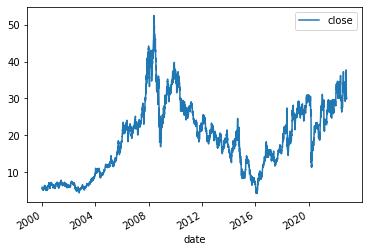

In [5]:
# Verificar as ações desde 2000
petr_dados[["close"]].plot()

<AxesSubplot:xlabel='date'>

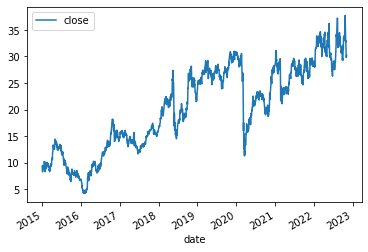

In [6]:
# Verificar a ação a partir 2015
petr_dados[petr_dados.index >= pd.to_datetime('2015-01-01')][["close"]].plot()

<AxesSubplot:xlabel='date'>

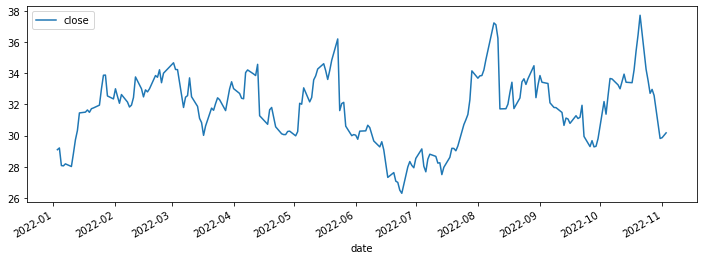

In [7]:
# Verificar a ação esse ano
fig, axs = plt.subplots(figsize=(12, 4))

petr_dados[petr_dados.index >= pd.to_datetime('2022-01-01')][["close"]].plot(ax=axs)

'----'

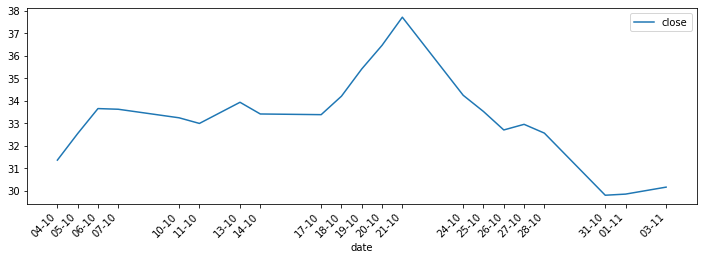

In [8]:
# Verificar o comportamento da ação no ultimo mês

fig, axs = plt.subplots(figsize=(12, 4))
dados_plot = petr_dados[petr_dados.index >= pd.to_datetime((datetime.now() - relativedelta(months=1)))][["close"]]
plot = dados_plot.plot(ax=axs)
x_labels = pd.to_datetime(dados_plot.index).strftime('%d-%m')

plot.set_xticks(dados_plot.index)
plot.set_xticklabels(x_labels, rotation=45)

"----"

> # Analisamos a API base da SELIC

In [9]:


r = requests.get('https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json')
retorno_api = r.json()

dt_selic = json_normalize(retorno_api) 
dt_selic

,data,valor
0,04/06/1986,0.065041
1,05/06/1986,0.067397
2,06/06/1986,0.066740
3,09/06/1986,0.068247
4,10/06/1986,0.067041
...,...,...
9123,26/10/2022,0.050788
9124,27/10/2022,0.050788
9125,28/10/2022,0.050788
9126,31/10/2022,0.050788


> Transformar o retorno da API em uma série, pra se adaptar ao dataset da ação e para que possamos fazer algumas analises 

In [10]:
def converterDataObj(x):
    return datetime.strptime(x, "%d/%m/%Y")
dt_selic["valor"].index = dt_selic["data"].apply(converterDataObj)
dt_selic["valor"].index.names = ['date']

selic = pd.Series(dt_selic["valor"])

#Converter valores pra float
selic = pd.to_numeric(selic)
selic

date
1986-06-04    0.065041
1986-06-05    0.067397
1986-06-06    0.066740
1986-06-09    0.068247
1986-06-10    0.067041
                ...   
2022-10-26    0.050788
2022-10-27    0.050788
2022-10-28    0.050788
2022-10-31    0.050788
2022-11-01    0.050788
Name: valor, Length: 9128, dtype: float64

> Filtrar para apenas nos anos 2000 pra cima, pois é onde se inicia nosso dataset

In [11]:

selic = selic[selic.index >= pd.to_datetime('2000-01-01')]

<AxesSubplot:xlabel='date'>

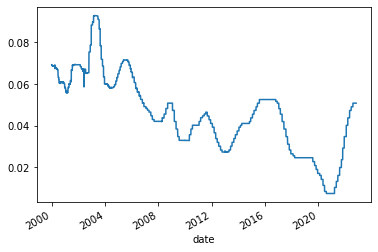

In [12]:
# Verificar o comportamento da SELIC durante os anos
selic.plot()

In [13]:
# Unir selic com a base PETR4
petr_dados = petr_dados.assign(selic = selic)

# Verificar se algum ficou em branco 
petr_dados.isna().sum()


open          0
volume        0
high          0
low           0
close         0
adjclose      0
dividends     0
splits        0
selic        63
dtype: int64

In [14]:
# Verificamos que será melhor fazer a predição dos ultimos dois anos, pois é onde houve uma oscilação menor 
petr_dados = petr_dados[petr_dados.index >= pd.to_datetime('2020-01-01')]

> Definimos um método para preenchimento dos dados faltantes

In [15]:
# Os dados em branco preenchemos com o ultimo valor
def preencherUltimoSelic (x):
     
    global selic     
    days = 1   
   
    while math.isnan(x['selic']):
        atual = pd.to_datetime(x.name - relativedelta(days=days)).strftime('%Y-%m-%d')
        if atual in selic.index :
            x['selic'] = selic.loc[atual]                  
        days += 1
    return x

selic_preenchidos = petr_dados[petr_dados["selic"].isna()].apply(preencherUltimoSelic, axis=1)

# Depois de descobrirmos os valores anteriores, vamos preenche-los na base final
for index,value in selic_preenchidos.iterrows() :    
    petr_dados["selic"][index] = value['selic']

# Por fim verificar se não há mais valores nulos
petr_dados.isna().sum()

open         0
volume       0
high         0
low          0
close        0
adjclose     0
dividends    0
splits       0
selic        0
dtype: int64

> Verificamos a correlação entre as colunas

In [16]:
corr = petr_dados.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,open,volume,high,low,close,adjclose,dividends,splits,selic
open,1.00,-0.16,1.00,1.00,0.99,0.83,0.04,nan,0.70
volume,-0.16,1.00,-0.13,-0.19,-0.16,-0.01,0.15,nan,0.05
high,1.00,-0.13,1.00,1.00,1.00,0.84,0.06,nan,0.71
low,1.00,-0.19,1.00,1.00,1.00,0.83,0.04,nan,0.69
close,0.99,-0.16,1.00,1.00,1.00,0.84,0.06,nan,0.70
adjclose,0.83,-0.01,0.84,0.83,0.84,1.00,0.09,nan,0.90
dividends,0.04,0.15,0.06,0.04,0.06,0.09,1.00,nan,0.09
splits,nan,nan,nan,nan,nan,nan,nan,nan,nan
selic,0.70,0.05,0.71,0.69,0.70,0.90,0.09,nan,1.00


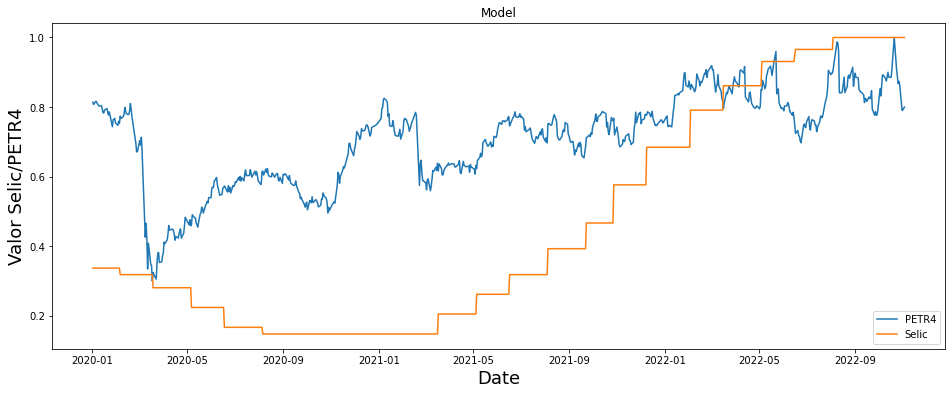

In [17]:
# Comparar a evolução do SELIC e As Açoes PETRA
valid = petr_dados.copy()
valid["close"]= valid["close"] / max(valid["close"])
valid['selic'] = valid["selic"] / max(valid["selic"])

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Valor Selic/PETR4', fontsize=18)

#plt.plot(train['Close'])
plt.plot(valid[['close', 'selic']])
plt.legend([ 'PETR4', 'Selic'], loc='lower right')
plt.show()

> Como a ideia é tentar prever diáriamente o valor fechamento, vamos criar 5 colunas <br>
> Com a porcentagem de aumento ou diminuição da ação nos ultimos 5 dias do dia em questão <br>
> Acreditamos que com isso consiguimos adicionar, alem do valor do selic, a influencia da queda ou valorizacao <br>
> Baseado se no passado ela foi valorizada ou não <br>

In [18]:


numeroDiasAnteriores = 3
menorData = petr_dados.iloc[numeroDiasAnteriores].name
menorClose = petr_dados.iloc[1]["close"]
def preencherPorcentagemAumento (x):     
    global petr_dados,numeroDiasAnteriores,menorData 
    if x.name <= menorData:
        count = 1
        while count <= numeroDiasAnteriores:
            x['val'+str(count)] = menorClose
            count +=1
        return x
    
    days = 1       
    
    count = 1
    closeValue = []
    while count <= numeroDiasAnteriores:
        x['val'+str(count)] = False
        while x['val'+str(count)] == False:    
            atual = pd.to_datetime(x.name - relativedelta(days=days)).strftime('%Y-%m-%d')
            if atual in petr_dados.index :
                closeValue.append(petr_dados.loc[atual]['close']) 
                x['val'+str(count)] =  closeValue[-1]          
            days += 1
        count +=1
    return x
 
petr_dados = petr_dados.apply(preencherPorcentagemAumento, axis=1)


In [19]:
# Vamos limpar as colunas que não usaremos 
petr_dados.drop(["open","high","low","volume","adjclose","splits","dividends"],axis=1,inplace=True)
petr_dados


,close,selic,val1,val2,val3
date,,,,,
2020-01-02,30.700001,0.017089,30.450001,30.450001,30.450001
2020-01-03,30.450001,0.017089,30.450001,30.450001,30.450001
2020-01-06,30.809999,0.017089,30.450001,30.450001,30.450001
2020-01-07,30.690001,0.017089,30.450001,30.450001,30.450001
2020-01-08,30.500000,0.017089,30.690001,30.809999,30.450001
...,...,...,...,...,...
2022-10-27,32.959999,0.050788,32.709999,33.529999,34.250000
2022-10-28,32.570000,0.050788,32.959999,32.709999,33.529999
2022-10-31,29.809999,0.050788,32.570000,32.959999,32.709999


In [20]:
# Escalar os dados
from sklearn.preprocessing import MinMaxScaler
petr_dados_formatado = pd.DataFrame()

#salvar o valor maximo pra ser usado posteriormente 
max_close = max(petr_dados["close"])

petr_dados_formatado["close"] = petr_dados["close"] / max(petr_dados["close"])
petr_dados_formatado["selic"] = petr_dados["selic"] / max(petr_dados["selic"])

# Escalar todas as colunas referente ao valor anterior
count = 1
while count <= numeroDiasAnteriores:
    petr_dados_formatado['val'+str(count)] = petr_dados['val'+str(count)] / max(petr_dados['val'+str(count)])   
    count +=1

petr_dados_formatado
#scaler = MinMaxScaler(feature_range=(0,1))
#petr_dados_formatado = scaler.fit_transform(petr_dados)
#petr_dados_formatado

,close,selic,val1,val2,val3
date,,,,,
2020-01-02,0.813892,0.336477,0.807264,0.807264,0.807264
2020-01-03,0.807264,0.336477,0.807264,0.807264,0.807264
2020-01-06,0.816808,0.336477,0.807264,0.807264,0.807264
2020-01-07,0.813627,0.336477,0.807264,0.807264,0.807264
2020-01-08,0.808590,0.336477,0.813627,0.816808,0.807264
...,...,...,...,...,...
2022-10-27,0.873807,1.000000,0.867179,0.888918,0.908006
2022-10-28,0.863468,1.000000,0.873807,0.867179,0.888918
2022-10-31,0.790297,1.000000,0.863468,0.873807,0.867179


In [21]:
# Separar treino e teste
from sklearn.model_selection import train_test_split

X = petr_dados_formatado.drop(["close"],axis=1)
y = petr_dados_formatado[["close"]]

training_data_len = int(np.ceil( len(petr_dados_formatado) * .80 ))

X_train = X[:training_data_len]
X_test = X[training_data_len:]
y_train = y[:training_data_len]
y_test = y[training_data_len:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [22]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [23]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import Callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = 100

    def on_batch_end(self, batch, logs={}):
       
        if logs.get('loss') < self.losses :           
            self.losses = logs.get('loss')


best = { "loss": 100 ,"loss_min": 100, "batch_size" : 0 , "model":None}
def executar_modelo(batch_size,epocas):
    global best
    #history = LossHistory()
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epocas,verbose=0)
    lossModelo = verificarErroMedio(model)
    if  lossModelo < best["loss"] :
        best["loss"] = lossModelo
        #best["loss_min"] = history.losses
        best["batch_size"] = batch_size
        best["model"] = model
    
    return model
    


batch_max = 150
comecarEncontrarParametros = 2
pularEncontrarParametros = 5
def encontrar_parametros(epocas):
    global comecarEncontrarParametros
    global batch_max
    while comecarEncontrarParametros <= batch_max:
       executar_modelo(comecarEncontrarParametros,epocas)
       comecarEncontrarParametros += pularEncontrarParametros

def verificarErroMedio(model):    
    predictions = model.predict(X_test)
    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    return rmse["close"]
executar_modelo(20,100)
#encontrar_parametros(100)
best

5/5 [==============================] - 1s 3ms/step


{'loss': 0.018465099995732436,
 'loss_min': 100,
 'batch_size': 20,
 'model': <keras.engine.sequential.Sequential at 0x21040d8a4f0>}

In [24]:
X_train.shape[1]

4

In [25]:
# Verificar o erro do modelo
model = best["model"]
predictions = model.predict(X_test)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 0s 3ms/step


close    0.018465
dtype: float64

1/1 [==============================] - 0s 22ms/step


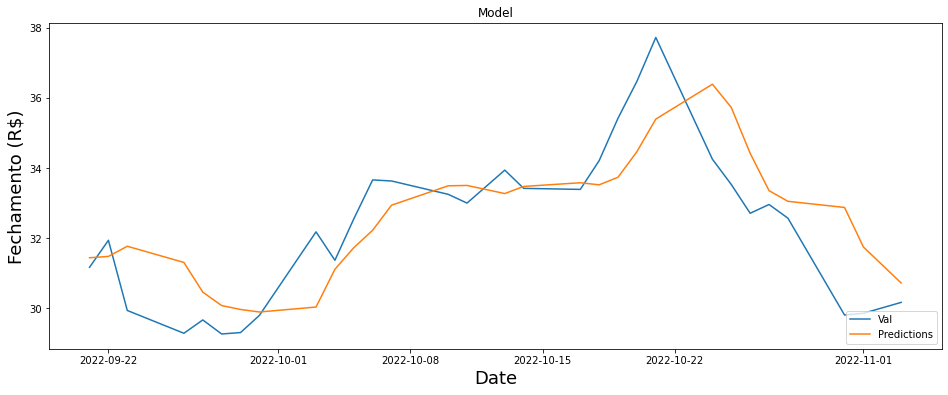

In [26]:
# plotar o resultado dos testes nos ultimos 30 dias
total = petr_dados_formatado.shape[0]
diasAnteriores = 30
predictions = model.predict(petr_dados_formatado[total-diasAnteriores:][["selic","val1","val2","val3"]])
#train = petr_dados[:200]
valid = petr_dados[total-diasAnteriores:]
valid['predictions'] = predictions * max_close
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Fechamento (R$)', fontsize=18)
#plt.plot(train['Close'])
plt.plot(valid[['close', 'predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()


4/4 [==============================] - 0s 2ms/step


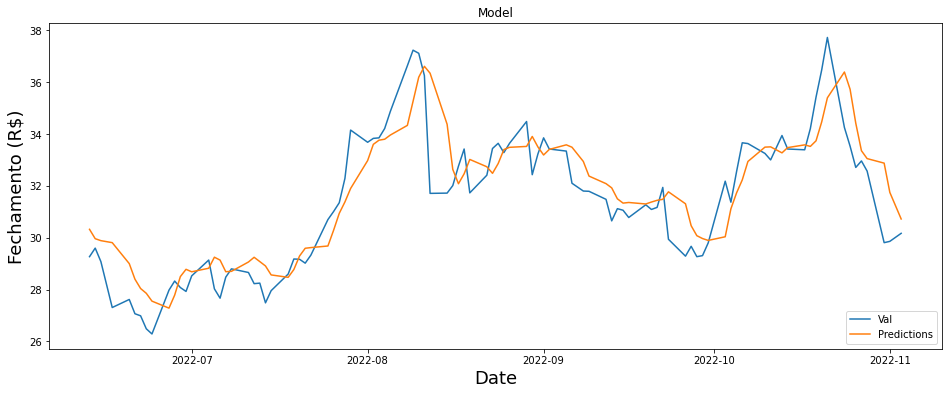

In [27]:
# plotar o resultado dos testes nos ultimos 100 dias
total = petr_dados_formatado.shape[0]
diasAnteriores = 100
predictions = model.predict(petr_dados_formatado[total-diasAnteriores:][["selic","val1","val2","val3"]])
#train = petr_dados[:200]
valid = petr_dados[total-diasAnteriores:]
valid['predictions'] = predictions * max_close
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Fechamento (R$)', fontsize=18)
#plt.plot(train['Close'])
plt.plot(valid[['close', 'predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

23/23 [==============================] - 0s 3ms/step


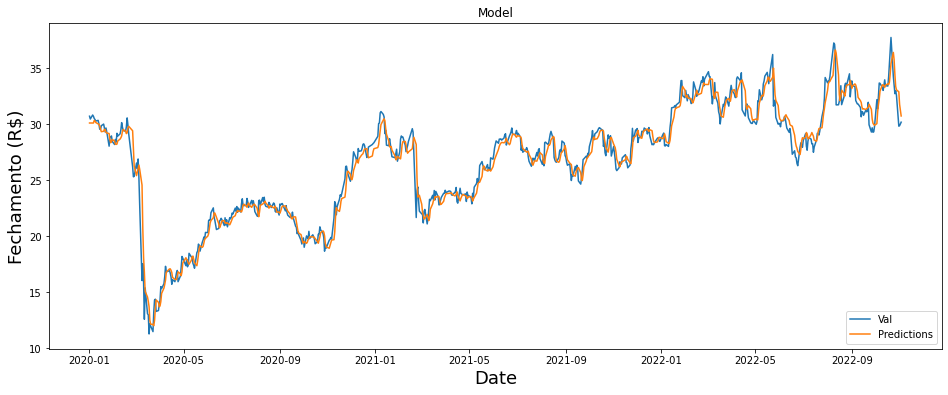

In [28]:
# plotar o resultado dos testes 
total = petr_dados_formatado.shape[0]
diasAnteriores = total
predictions = model.predict(petr_dados_formatado[total-diasAnteriores:][["selic","val1","val2","val3"]])
#train = petr_dados[:200]
valid = petr_dados[total-diasAnteriores:]
valid['predictions'] = predictions * max_close
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Fechamento (R$)', fontsize=18)
#plt.plot(train['Close'])
plt.plot(valid[['close', 'predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

In [29]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.version)

Num GPUs Available:  0
<module 'tensorflow._api.v2.version' from 'C:\\Users\\Paulo Brandao\\AppData\\Roaming\\Python\\Python39\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>


In [30]:
# Como não conseguimos um bom resultado, vamos adicionar o valor do Crude Oil
oil = Ticker("CL=F")
oil = oil.history(start="2020-01-01",end="2022-11-01")
oil.index = oil.index.unique(level='date')
oil.index = pd.to_datetime(oil.index)
oil

,open,close,volume,low,high,adjclose
date,,,,,,
2020-01-02,61.599998,61.180000,486873.0,60.639999,61.599998,61.180000
2020-01-03,61.180000,63.049999,885861.0,61.130001,64.089996,63.049999
2020-01-06,63.709999,63.270000,724236.0,62.639999,64.720001,63.270000
2020-01-07,62.910000,62.700001,582649.0,62.110001,63.150002,62.700001
2020-01-08,62.840000,59.610001,1205710.0,59.150002,65.650002,59.610001
...,...,...,...,...,...,...
2022-10-25,84.879997,85.320000,240441.0,83.059998,86.029999,85.320000
2022-10-26,85.070000,87.910004,287182.0,84.139999,88.410004,87.910004
2022-10-27,88.260002,89.080002,292556.0,87.330002,89.790001,89.080002


In [31]:
# Filtrar para apenas nos anos 2020 pra cima, pois é onde se inicia nosso dataset

oil = oil[oil.index >= pd.to_datetime('2020-01-01')]
oil

,open,close,volume,low,high,adjclose
date,,,,,,
2020-01-02,61.599998,61.180000,486873.0,60.639999,61.599998,61.180000
2020-01-03,61.180000,63.049999,885861.0,61.130001,64.089996,63.049999
2020-01-06,63.709999,63.270000,724236.0,62.639999,64.720001,63.270000
2020-01-07,62.910000,62.700001,582649.0,62.110001,63.150002,62.700001
2020-01-08,62.840000,59.610001,1205710.0,59.150002,65.650002,59.610001
...,...,...,...,...,...,...
2022-10-25,84.879997,85.320000,240441.0,83.059998,86.029999,85.320000
2022-10-26,85.070000,87.910004,287182.0,84.139999,88.410004,87.910004
2022-10-27,88.260002,89.080002,292556.0,87.330002,89.790001,89.080002


In [32]:
# adicionar o valor do oil ao dataset
petr_dados = petr_dados.assign(oil = oil["close"])
petr_dados

,close,selic,val1,val2,val3,oil
date,,,,,,
2020-01-02,30.700001,0.017089,30.450001,30.450001,30.450001,61.180000
2020-01-03,30.450001,0.017089,30.450001,30.450001,30.450001,63.049999
2020-01-06,30.809999,0.017089,30.450001,30.450001,30.450001,63.270000
2020-01-07,30.690001,0.017089,30.450001,30.450001,30.450001,62.700001
2020-01-08,30.500000,0.017089,30.690001,30.809999,30.450001,59.610001
...,...,...,...,...,...,...
2022-10-27,32.959999,0.050788,32.709999,33.529999,34.250000,89.080002
2022-10-28,32.570000,0.050788,32.959999,32.709999,33.529999,87.900002
2022-10-31,29.809999,0.050788,32.570000,32.959999,32.709999,86.529999


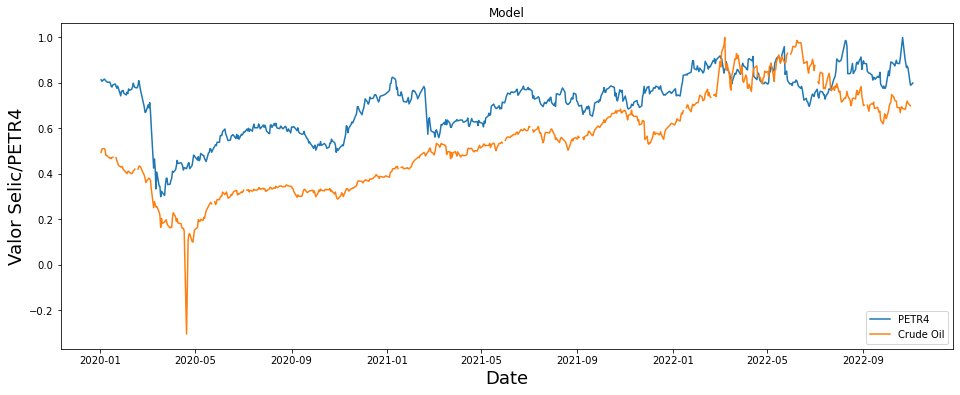

In [33]:
# Comparar a evolução do Oil e as Açoes PETR4

valid = petr_dados.copy()
valid["close"]= valid["close"] / max(valid["close"])
valid['oil'] = valid["oil"] / max(valid["oil"])
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Valor Selic/PETR4', fontsize=18)
#plt.plot(train['Close'])
plt.plot(valid[['close', 'oil']])
plt.legend([ 'PETR4', 'Crude Oil'], loc='lower right')
plt.show()

In [34]:
# Remover outliers

low = .00000000001
high = .9999999999
quant_df = petr_dados[["oil"]].quantile([low, high])


petr_dados["oil"] = petr_dados[["oil"]].apply(lambda x: x[(x>quant_df.loc[low,x.name]) & 
                                    (x < quant_df.loc[high,x.name])], axis=0)["oil"]

petr_dados

,close,selic,val1,val2,val3,oil
date,,,,,,
2020-01-02,30.700001,0.017089,30.450001,30.450001,30.450001,61.180000
2020-01-03,30.450001,0.017089,30.450001,30.450001,30.450001,63.049999
2020-01-06,30.809999,0.017089,30.450001,30.450001,30.450001,63.270000
2020-01-07,30.690001,0.017089,30.450001,30.450001,30.450001,62.700001
2020-01-08,30.500000,0.017089,30.690001,30.809999,30.450001,59.610001
...,...,...,...,...,...,...
2022-10-27,32.959999,0.050788,32.709999,33.529999,34.250000,89.080002
2022-10-28,32.570000,0.050788,32.959999,32.709999,33.529999,87.900002
2022-10-31,29.809999,0.050788,32.570000,32.959999,32.709999,86.529999


In [35]:
#Verificar se algum ficou nulo
petr_dados.isna().sum()

close     0
selic     0
val1      0
val2      0
val3      0
oil      18
dtype: int64

In [36]:
# Os valores em branco vamos preencher com o ultimo valor

def preencherUltimoOil (x):
     
    global oil     
    days = 1   
   
    while math.isnan(x['oil']):
        atual = pd.to_datetime(x.name - relativedelta(days=days)).strftime('%Y-%m-%d')
        
        if atual in oil.index :
            x['oil'] = oil.loc[atual]["close"]                  
        days += 1
    return x

oil_preenchidos = petr_dados[petr_dados["oil"].isna()].apply(preencherUltimoOil, axis=1)

# depois que descobrimos os valores anteriores, vamos preenche-los na base final

for index,value in oil_preenchidos.iterrows() :    
    petr_dados["oil"][index] = value['oil']

# por fim verificar se não há mais valores nulos

petr_dados.isna().sum()

close    0
selic    0
val1     0
val2     0
val3     0
oil      0
dtype: int64

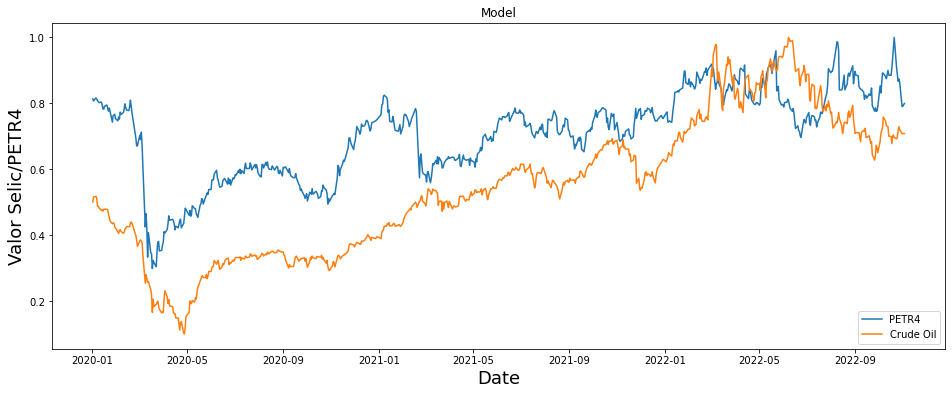

,close,selic,val1,val2,val3,oil
date,,,,,,
2020-01-02,30.700001,0.017089,30.450001,30.450001,30.450001,61.180000
2020-01-03,30.450001,0.017089,30.450001,30.450001,30.450001,63.049999
2020-01-06,30.809999,0.017089,30.450001,30.450001,30.450001,63.270000
2020-01-07,30.690001,0.017089,30.450001,30.450001,30.450001,62.700001
2020-01-08,30.500000,0.017089,30.690001,30.809999,30.450001,59.610001
...,...,...,...,...,...,...
2022-10-27,32.959999,0.050788,32.709999,33.529999,34.250000,89.080002
2022-10-28,32.570000,0.050788,32.959999,32.709999,33.529999,87.900002
2022-10-31,29.809999,0.050788,32.570000,32.959999,32.709999,86.529999


In [37]:
# plotar Novamente 
valid = petr_dados.copy()
valid["close"]= valid["close"] / max(valid["close"])
valid['oil'] = valid["oil"] / max(valid["oil"])

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Valor Selic/PETR4', fontsize=18)

#plt.plot(train['Close'])
plt.plot(valid[['close', 'oil']])
plt.legend([ 'PETR4', 'Crude Oil'], loc='lower right')
plt.show()
petr_dados

In [38]:
# O mesmo que eu fiz com o valor close da ação nos ultimos 5 dias, vou fazer com o oil
numeroDiasAnterioresOil = 1
menorData = petr_dados.iloc[numeroDiasAnterioresOil].name
menorClose = petr_dados.iloc[1]["oil"]
def preencherPorcentagemAumentoOil (x):     
    global petr_dados,numeroDiasAnteriores,menorData 
    if x.name <= menorData:
        count = 1
        while count <= numeroDiasAnterioresOil:
            x['oil'+str(count)] = menorClose
            count +=1
        return x
    
    days = 1       
    
    count = 1
    oilValue = []
    while count <= numeroDiasAnterioresOil:
        x['oil'+str(count)] = False
        while x['oil'+str(count)] == False:    
            atual = pd.to_datetime(x.name - relativedelta(days=days)).strftime('%Y-%m-%d')
            if atual in petr_dados.index :
                oilValue.append(petr_dados.loc[atual]['oil'])                   
                x['oil'+str(count)] = oilValue[-1]          
            days += 1
        count +=1
    return x
 
petr_dados = petr_dados.apply(preencherPorcentagemAumentoOil, axis=1)


In [39]:
petr_dados

,close,selic,val1,val2,val3,oil,oil1
date,,,,,,,
2020-01-02,30.700001,0.017089,30.450001,30.450001,30.450001,61.180000,63.049999
2020-01-03,30.450001,0.017089,30.450001,30.450001,30.450001,63.049999,63.049999
2020-01-06,30.809999,0.017089,30.450001,30.450001,30.450001,63.270000,63.049999
2020-01-07,30.690001,0.017089,30.450001,30.450001,30.450001,62.700001,63.270000
2020-01-08,30.500000,0.017089,30.690001,30.809999,30.450001,59.610001,62.700001
...,...,...,...,...,...,...,...
2022-10-27,32.959999,0.050788,32.709999,33.529999,34.250000,89.080002,87.910004
2022-10-28,32.570000,0.050788,32.959999,32.709999,33.529999,87.900002,89.080002
2022-10-31,29.809999,0.050788,32.570000,32.959999,32.709999,86.529999,87.900002


In [40]:
# Escalar os dados
from sklearn.preprocessing import MinMaxScaler
petr_dados_formatado = pd.DataFrame()

#salvar o valor maximo pra ser usado posteriormente 
max_close = max(petr_dados["close"])

petr_dados_formatado["close"] = petr_dados["close"] / max(petr_dados["close"])
petr_dados_formatado["selic"] = petr_dados["selic"] / max(petr_dados["selic"])

# Escalar todas as colunas referente ao valor anterior
count = 1
while count <= numeroDiasAnteriores:
    petr_dados_formatado['val'+str(count)] = petr_dados['val'+str(count)] / max(petr_dados['val'+str(count)])   
    count +=1

countOil = 1
while countOil <= numeroDiasAnterioresOil:
    petr_dados_formatado['oil'+str(countOil)] = petr_dados['oil'+str(countOil)] / max(petr_dados['oil'+str(countOil)])   
    countOil +=1


petr_dados_formatado
#scaler = MinMaxScaler(feature_range=(0,1))
#petr_dados_formatado = scaler.fit_transform(petr_dados)
#petr_dados_formatado

,close,selic,val1,val2,val3,oil1
date,,,,,,
2020-01-02,0.813892,0.336477,0.807264,0.807264,0.807264,0.516338
2020-01-03,0.807264,0.336477,0.807264,0.807264,0.807264,0.516338
2020-01-06,0.816808,0.336477,0.807264,0.807264,0.807264,0.516338
2020-01-07,0.813627,0.336477,0.807264,0.807264,0.807264,0.518139
2020-01-08,0.808590,0.336477,0.813627,0.816808,0.807264,0.513471
...,...,...,...,...,...,...
2022-10-27,0.873807,1.000000,0.867179,0.888918,0.908006,0.719925
2022-10-28,0.863468,1.000000,0.873807,0.867179,0.888918,0.729506
2022-10-31,0.790297,1.000000,0.863468,0.873807,0.867179,0.719843


In [41]:
# Separar treino e teste
from sklearn.model_selection import train_test_split

X = petr_dados_formatado.drop(["close"],axis=1)
y = petr_dados_formatado[["close"]]

training_data_len = int(np.ceil( len(petr_dados_formatado) * .80 ))

X_train = X[:training_data_len]
X_test = X[training_data_len:]
y_train = y[:training_data_len]
y_test = y[training_data_len:]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [42]:
#batch_max = 300
#comecarEncontrarParametros = 10
#pularEncontrarParametros = 30
#encontrar_parametros(1000)
model = executar_modelo(20,100)
best

5/5 [==============================] - 1s 3ms/step


{'loss': 0.018465099995732436,
 'loss_min': 100,
 'batch_size': 20,
 'model': <keras.engine.sequential.Sequential at 0x21040d8a4f0>}

In [43]:
#model = best["model"]
predictions = model.predict(X_test)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions * max_close - y_test * max_close) ** 2)))
rmse["close"]

5/5 [==============================] - 0s 3ms/step


1.2522560554646447

18/18 [==============================] - 0s 2ms/step


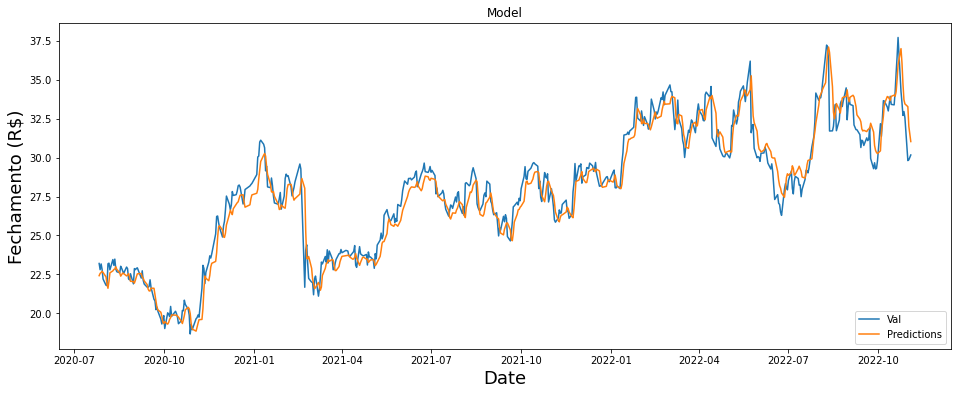

In [44]:
# plotar o resultado dos testes 
total = petr_dados_formatado.shape[0]
diasAnteriores = training_data_len
predictions = model.predict(petr_dados_formatado[total-diasAnteriores:][["selic","val1","val2","val3","oil1"]])
#train = petr_dados[:200]
valid = petr_dados_formatado[total-diasAnteriores:][["close"]] * max_close
valid['predictions'] = predictions * max_close
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Fechamento (R$)', fontsize=18)
#plt.plot(train['Close'])
plt.plot(valid[['close', 'predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

5/5 [==============================] - 0s 3ms/step


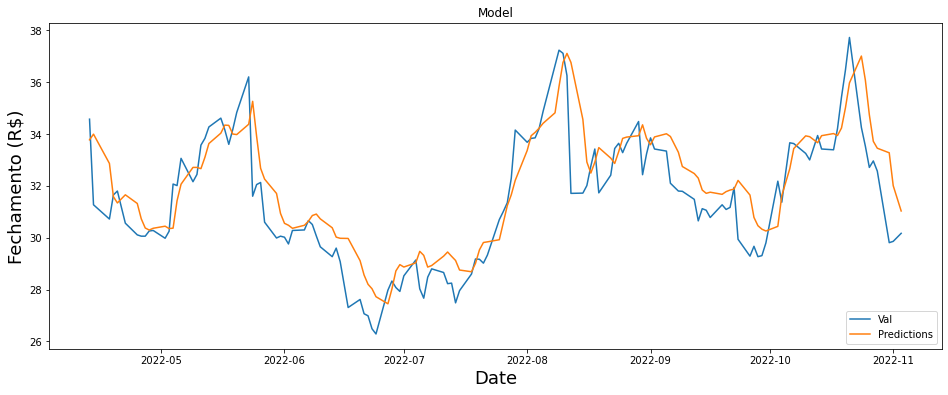

In [45]:
# plotar o resultado dos testes
total = petr_dados_formatado.shape[0]
diasAnteriores = total - training_data_len
predictions = model.predict(petr_dados_formatado[total-diasAnteriores:][["selic","val1","val2","val3","oil1"]])

#train = petr_dados[:200]
valid = petr_dados_formatado[total-diasAnteriores:][["close"]] * max_close
valid['predictions'] = predictions * max_close

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Fechamento (R$)', fontsize=18)

#plt.plot(train['Close'])
plt.plot(valid[['close', 'predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()